# Presentation of the results

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import json
import re
import geopandas as gpd
from collections import Counter
import squarify
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, widgets, Button, HBox, VBox, Output
import time
import numpy as np
from scipy.signal import correlate
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

from IPython.display import display
from itertools import combinations

import nbformat
from IPython.core.interactiveshell import InteractiveShell

from IPython.display import Image

from gensim.corpora import Dictionary
from gensim.models import LdaModel
from pprint import pprint
from nltk import pos_tag, word_tokenize

from torch.quantization import quantize_dynamic
from sentence_transformers import SentenceTransformer, util, InputExample, losses
from sklearn.cluster import AgglomerativeClustering, MiniBatchKMeans
from torch.utils.data import DataLoader
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, silhouette_score
from tqdm import tqdm
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain_ollama import OllamaLLM
#nltk.download("stopwords")
#nltk.download('punkt_tab')

In [2]:
# Script to load the notebook utils.ipynb
import nbformat
from IPython.core.interactiveshell import InteractiveShell

# Load the notebook utils.ipynb
with open('./src/scripts/utils.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

# Create an instance of InteractiveShell
shell = InteractiveShell.instance()

# Execute the notebook utils.ipynb
for cell in nb.cells:
    if cell.cell_type == 'code':
        shell.run_cell(cell.source)

>The merged_df.tsv can be generated by running the data_treatment.ipynb notebook in src/data. We didn't push it on github because of its size.

In [24]:
# Opening of the treated datasets
characters_df = pd.read_csv('src/data/character.metadata.tsv', sep='\t')
movies_df = pd.read_csv('src/data/movie.metadata.tsv', sep='\t')
name_cluster_df = pd.read_csv('src/data/name.clusters.txt', sep='\t')
plot_summary_df = pd.read_csv('src/data/plot_summaries.txt', sep='\t')
tv_tropes_df = pd.read_csv('src/data/tvtropes.clusters.txt', sep='\t')
merged_df = pd.read_csv('src/data/merged_df.tsv', sep='\t')
wf_wikipedia = pd.read_csv('src/data/word_frequencies_wikipedia.csv')
wf_summaries = pd.read_csv('src/data/word_frequencies_summaries.csv')
wf_wikipedia_summaires = pd.read_csv("src/data/word_frequencies_summaries_wikipedia.csv")

# 1. Overivew of the database

>  Building on the P2 phase of the project, we decided to retain specific graphs that were particularly relevant to the data story. We felt it was both interesting and important to provide a concise overview of the database contents, giving readers a general understanding of the data. The selected visualizations include the breakdown of the number of films produced by country, the evolution of the most common genres by decade, the male-to-female ratio by decade, and the male-to-female ratio by genre and decade

## *1.1 Repartition of movie production per country*

> The origin of the films is an important factor in understanding just how diverse the database is from a global perspective and this is interesting to show for our data story as an introduction.

/opt/anaconda3/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 10 classes. Setting k to 7.
  self.bins = quantile(y, k=k)


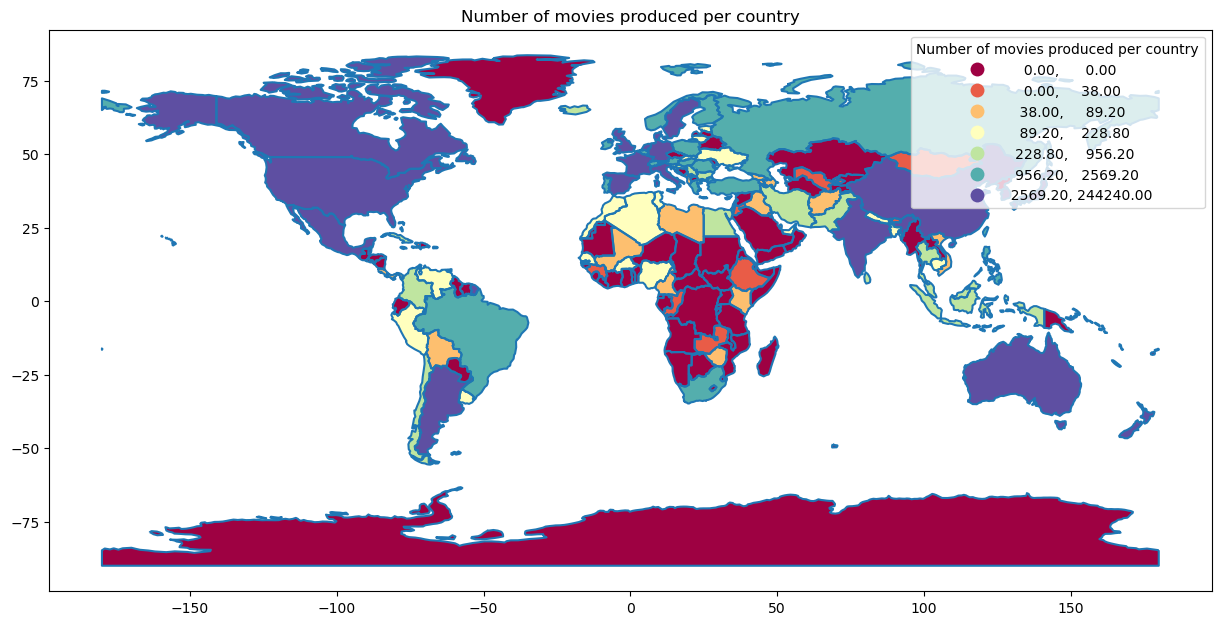

In [20]:
# Creation of a new column called "country_list" in movies_df to have a list of all countries of a movie
merged_df['country_list']=merged_df['Movie_countries'].astype(str).apply(extract_string)

# Transformation of the country list into individual rows
exploded_countries = merged_df.explode('country_list')

# Counting the number of movies per country
country_counts = exploded_countries['country_list'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Sorting the countries by number of movies
country_counts = country_counts.sort_values(by='count', ascending=False)

# Loading the shapefile of the world
shapefile_path = '/home/sara/Dropbox/epfl/master/MA1/ADA/ada-2024-project-analyticaldementialavengers/others/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Fusion of the movie data with the shapefile data
world = world.merge(country_counts, how='left', left_on='NAME', right_on='country')

# Fill the NaN values with 0
world['count'] = world['count'].fillna(0)

# Adjusting the number of classes for the choropleth map
unique_counts = world['count'].nunique()
k = min(10, unique_counts)

# Creation of the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
world.plot(column='count', ax=ax, legend=True,
           legend_kwds={'title': "Number of movies produced per country"},
           cmap='Spectral', scheme='quantiles', k=k)
plt.title('Number of movies produced per country')
plt.show()

### *1.2 Gender analysis*

> Examining the male-to-female ratio provides valuable insights into character representation and serves as a key aspect for readers of our data story.

In [ ]:
# Prepare the data for each decade
decade_gender_counts = merged_df.groupby(['Decade', 'Actor_gender']).size().reset_index(name='count')

# Creation of a graph with plotly
fig = px.bar(decade_gender_counts, x='Decade', y='count', color='Actor_gender', barmode='stack',
             labels={'count': 'Number of movies', 'Decade': 'Decade', 'Actor_gender': 'Genre'},
             title='Repartition men-women for the decades')
fig.show()

# Save the graph as an HTML file
fig.write_html("html/repartition_gender_decades.html")

In [ ]:
# Creation of frames for each decade
frames = []
for decade in decade_gender_counts['Decade'].unique():
    frame_data = decade_gender_counts[decade_gender_counts['Decade'] == decade]
    frame = go.Frame(data=[go.Pie(labels=frame_data['Actor_gender'], values=frame_data['count'])],
                     name=str(decade))
    frames.append(frame)

# Creation of the initial graph
initial_data = decade_gender_counts[decade_gender_counts['Decade'] == decade_gender_counts['Decade'].min()]
fig = go.Figure(data=[go.Pie(labels=initial_data['Actor_gender'], values=initial_data['count'])])

# Adding the frames to the graph
fig.frames = frames

# Adding the play/pause button
fig.update_layout(
    title='Proportion of men and women per decade',
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 1000, 'redraw': True}, 'fromcurrent': True}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }]
)

# Adding the timeline
fig.update_layout(
    sliders=[{
        'steps': [
            {
                'args': [[str(decade)], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}],
                'label': str(decade),
                'method': 'animate'
            } for decade in decade_gender_counts['Decade'].unique()
        ],
        'transition': {'duration': 300},
        'x': 0.1,
        'len': 0.9,
        'xanchor': 'left',
        'y': -0.1,
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Decade:',
            'visible': True,
            'xanchor': 'right'
        },
        'tickcolor': 'white'
    }]
)
fig.show()

# Save the graph as an HTML file
fig.write_html("html/proportion_gender_decades.html")

### *1.3. Genre analysis*

> Genre plays an intriguing role in shaping characters, making it valuable to showcase its evolution to readers. Additionally, we chose to represent the evolution of gender and genre within the same graph, enabling readers to form their own interpretations of the trends.

In [185]:
# Combining all genres in a single list
all_genres = [genre for sublist in merged_df['genre_list'] for genre in sublist]

# Counting the number of unique genres
unique_genres = set(all_genres)
num_unique_genres = len(unique_genres)

print(f"Number of unique genres : {num_unique_genres}")

Number of unique genres : 360


In [ ]:
# Creation of a dynimic graph with a timeline
fig = px.bar(top_genres_by_decade, x='genre_list', y='count', color='genre_list', 
             animation_frame='Decade', 
             labels={'count': 'Number of movies', 'genre_list': 'Genre'},
             title='Evolution of the most common genres per decade')

# Adjust the layout to slow down the animation
fig.update_layout(
    xaxis_tickangle=-45,
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 2000, 'redraw': True}, 'fromcurrent': True, 'transition': {'duration': 2000}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }]
)

# Adding the timeline
fig.update_layout(
    sliders=[{
        'steps': [
            {
                'args': [[str(decade)], {'frame': {'duration': 2000, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 2000}}],
                'label': str(decade),
                'method': 'animate'
            } for decade in top_genres_by_decade['Decade'].unique()
        ],
        'transition': {'duration': 2000},
        'x': 0.1,
        'len': 0.9,
        'xanchor': 'left',
        'y': -0.1,
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Decade:',
            'visible': True,
            'xanchor': 'right'
        },
        'tickcolor': 'white'
    }]
)
fig.show()

# Save the graph as an HTML file
fig.write_html("html/genres_evolution_decades.html")

In [ ]:
# Filter the data to keep only the most common genres
filtered_df = exploded_df[exploded_df['genre_list'].isin(top_genres_by_decade['genre_list'])]

# Compute the number of occurrences of each genre and gender of actor per decade
gender_genre_counts_by_decade = filtered_df.groupby(['Decade', 'genre_list', 'Actor_gender']).size().reset_index(name='count')

# Createion of a dynamic graph with a timeline
fig = px.bar(gender_genre_counts_by_decade, x='genre_list', y='count', color='Actor_gender', 
             animation_frame='Decade', 
             labels={'count': 'Number of movies', 'genre_list': 'Genre', 'Actor_gender': 'Genre of the actor'},
             title='Proportion of men and women per genre per decade')

# Adjust the layout to slow down the animation
fig.update_layout(
    xaxis_tickangle=-45,
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 2000, 'redraw': True}, 'fromcurrent': True, 'transition': {'duration': 2000}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }]
)

# Adding the timeline
fig.update_layout(
    sliders=[{
        'steps': [
            {
                'args': [[str(decade)], {'frame': {'duration': 2000, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 2000}}],
                'label': str(decade),
                'method': 'animate'
            } for decade in gender_genre_counts_by_decade['Decade'].unique()
        ],
        'transition': {'duration': 2000},
        'x': 0.1,
        'len': 0.9,
        'xanchor': 'left',
        'y': -0.1,
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Decade:',
            'visible': True,
            'xanchor': 'right'
        },
        'tickcolor': 'white'
    }]
)
fig.show()

# Save the graph as an HTML file
fig.write_html("html/evolution_gender_per_genre_decades.html")

## *1.4 Conclusion*

> We retained the most insightful graphs from the P2 phase that are relevant to the data story. Interactive plots proved to be the ideal choice, as they allow readers to independently explore the evolution of each parameter. No additional analysis is provided here, as these were conducted during P2 and are already included in the data story

# 2. Timeline extraction

> In order to obtain historical data that we would be able to analyse and compare with our summaries dataset, we finally decided to use the wikipedia page of each decade from 1900 to 2010. We proceeded this way : download the wikipedia pages from wikipedia as PDF -> turn them into TXT file.

# 3. Latent Dirichlet Allocation (LDA) model

>We used this methode to analyse the most frequent words in the summaries of films in the plot_summaries dataset, the wikipedia page describing, and ten wikipedia summaries of the movies listed in merged_df proceeding by decade from 1900 to 2010 (included). 

## *3.1 testing the method*

> To test the Latent Dirichlet Allocation (LDA) without having a ton run the code for a certain time, we are going to apply it only to the first summary of the list. To do this, copy the first line of plot_summaries into a new dataframe. 

In [15]:
one_line_df = plot_summary_df.iloc[:1].copy()
print(one_line_df)

   movie_id                                       plot_summary
0  23890098  Shlykov, a hard-working taxi driver and Lyosha...


> We then transform the type of the cell into a list of string and split the words composing it using the function text_split. This function use the function word_tokenize from NLTK to create a token with each word and the function pos_tag of NLTK to attribute a tag to each word with its grammatical class. We then choose to keep only the nouns. 

In [16]:
one_line_df['split'] = one_line_df['plot_summary'].apply(text_split)

>The splitted words are converted into bag-of-words. The function bag_of_words create a dictionary that maps each word to a unique id.

In [17]:
one_line_df['corpus'] = one_line_df['split'].apply(bag_of_words)

> We are finally ready to train our LDA model. To do this, we apply the function LdaModel of Gensim. This will return the learned topic distributions and the word distributions for each topic.

In [18]:
one_line_df['lda'] = one_line_df.apply(lda, axis=1)

>We are ready to print this distribution.

In [19]:
pprint(one_line_df['lda'].apply(get_topics).tolist())

[[(0,
   '0.100*"bizarre" + 0.100*"prejudices" + 0.100*"Lyosha" + 0.100*"arent" + '
   '0.100*"taxi" + 0.100*"driver" + 0.100*"lovehate" + 0.100*"relationship" + '
   '0.100*"saxophonist" + 0.100*"Shlykov"')]]


> We can see that be obtain a list of words preceded by their frequency in the text we worked on. Here the results are not very interesting as the summaries is rather short and therefore the frequencies are the same. We can choose to plot this into a bar plot, but first we need to extract the data from this list in a form that suits us. To do this, we can again use the function get_topic, as it has a a possibility to return the output in a chosen variable. We then transfer the data in a dataframe, easier to plot. To do this, we use the function extract that will adapt to the format of the list and stock in a dataframe the words and their respective frequencies.

In [20]:
word_one_line = one_line_df['lda'].apply(get_topics)

In [21]:
one_line = extract(word_one_line)

#We set the words as the indexes of the dataframe
one_line.set_index('word', inplace = True)

> We can finally plot the frequencies of the words.

<Figure size 1000x600 with 0 Axes>

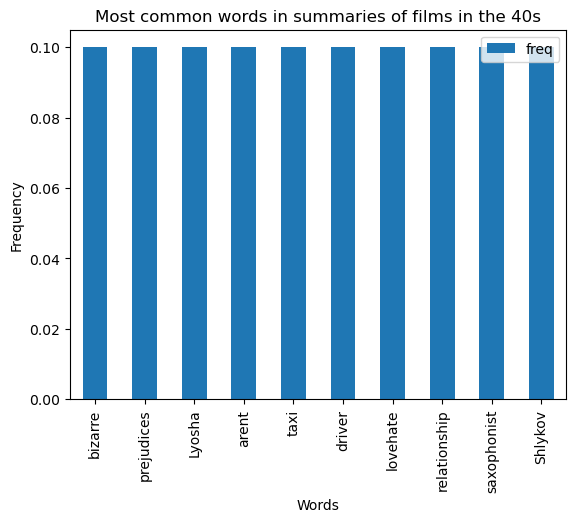

In [22]:
plt.figure(figsize=(10, 6))
one_line.plot(kind='bar')

plt.title('Most common words in summaries of films in the 40s')
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.show()

> Again, this plot does not really show anything interesting, but we tested the method on some of our data and we can now apply it to a more concrete exemple.

## *3.2 LDA correlations between wikipedia decade page and movies summaries*

>From here, the LDA analysis was performed in src/data/by_decade_data_treatment.ipynb

In [7]:
#selecting common words between the two ldas
common_columns = set(wf_wikipedia.columns).intersection(wf_summaries.columns)
wf_wikipedia_filtered = wf_wikipedia[list(common_columns)]
wf_summaries_filtered = wf_summaries[list(common_columns)]

In [8]:
wf_summaries_filtered

,woman,death,people,Unnamed: 0,time,end,become,film,Jerry,Joe,de,car,films,show,years,group,shows,home
0,0.004,0.000,0.000,1900,0.004,0.003,0.000,0.017,0.000,0.000,0.003,0.000,0.003,0.000,0.000,0.000,0.003,0.000
1,0.003,0.000,0.000,1910,0.002,0.000,0.000,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.003
2,0.003,0.002,0.000,1920,0.003,0.002,0.002,0.004,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.000,0.000,0.003
3,0.002,0.000,0.000,1930,0.002,0.000,0.001,0.002,0.000,0.000,0.000,0.000,0.000,0.002,0.001,0.000,0.000,0.003
4,0.002,0.002,0.000,1940,0.003,0.001,0.000,0.002,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003
5,0.002,0.002,0.000,1950,0.003,0.002,0.000,0.002,0.003,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003
6,0.002,0.002,0.000,1960,0.003,0.001,0.001,0.003,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.001,0.000,0.003
7,0.002,0.002,0.000,1970,0.003,0.001,0.001,0.003,0.000,0.000,0.000,0.002,0.000,0.000,0.001,0.001,0.000,0.003
8,0.002,0.002,0.000,1980,0.003,0.001,0.001,0.003,0.000,0.000,0.000,0.003,0.000,0.000,0.002,0.002,0.000,0.003
9,0.002,0.002,0.000,1990,0.003,0.000,0.001,0.003,0.000,0.000,0.000,0.002,0.000,0.000,0.002,0.001,0.000,0.003


In [9]:
wf_wikipedia_filtered

,woman,death,people,Unnamed: 0,time,end,become,film,Jerry,Joe,de,car,films,show,years,group,shows,home
0,0.000,0.000,0.002,1900s,0.001,0.000,0.000,0.000,0.000,0.000,0.002,0.001,0.000,0.000,0.001,0.000,0.000,0.000
1,0.000,0.002,0.004,1910s,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000
2,0.000,0.000,0.000,1920s,0.002,0.000,0.000,0.004,0.000,0.000,0.002,0.000,0.002,0.000,0.002,0.000,0.000,0.000
3,0.000,0.000,0.001,1930s,0.000,0.000,0.000,0.004,0.000,0.000,0.000,0.000,0.002,0.000,0.002,0.000,0.000,0.000
4,0.000,0.001,0.002,1940s,0.000,0.000,0.000,0.001,0.000,0.002,0.003,0.000,0.002,0.000,0.000,0.000,0.000,0.000
5,0.000,0.001,0.002,1950s,0.002,0.000,0.000,0.000,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.000,0.001,0.002,1960s,0.002,0.002,0.000,0.001,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.001,0.000,0.000
7,0.001,0.000,0.002,1970s,0.001,0.002,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.001,0.000
8,0.000,0.000,0.003,1980s,0.002,0.003,0.000,0.002,0.000,0.000,0.000,0.000,0.003,0.000,0.002,0.000,0.000,0.001
9,0.000,0.000,0.002,1990s,0.002,0.002,0.001,0.000,0.000,0.000,0.000,0.000,0.002,0.001,0.002,0.000,0.002,0.000


> We plot some of those common word frequencies

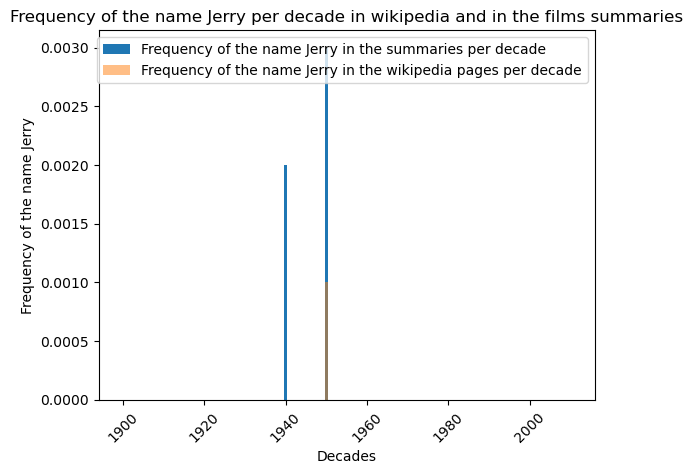

In [10]:
decade_name = [1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010]
plt.bar(decade_name,wf_summaries_filtered['Jerry'], label = 'Frequency of the name Jerry in the summaries per decade')
plt.bar(decade_name,wf_wikipedia_filtered['Jerry'], alpha = 0.5,label = 'Frequency of the name Jerry in the wikipedia pages per decade')
plt.xlabel('Decades')
plt.ylabel('Frequency of the name Jerry')
plt.title('Frequency of the name Jerry per decade in wikipedia and in the films summaries')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [11]:
# computing the pearson p-value 
correlation, p_value = pearsonr(wf_summaries_filtered['Jerry'], wf_wikipedia_filtered['Jerry'])
p_value

0.0011891694323429374

>The name Jerry was apparently very popular in the 1940s-1950s.

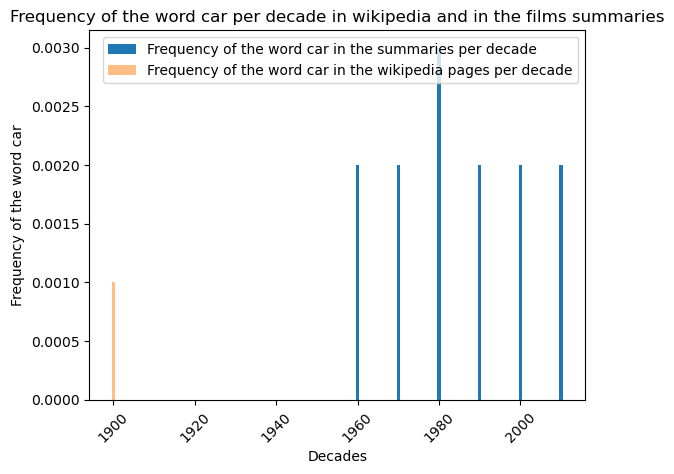

In [12]:
plt.bar(decade_name,wf_summaries_filtered['car'], label = 'Frequency of the word car in the summaries per decade')
plt.bar(decade_name,wf_wikipedia_filtered['car'], alpha = 0.5,label = 'Frequency of the word car in the wikipedia pages per decade')
plt.xlabel('Decades')
plt.ylabel('Frequency of the word car')
plt.title('Frequency of the word car per decade in wikipedia and in the films summaries')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [14]:
# computing the pearson p-value 
correlation, p_value = pearsonr(wf_summaries_filtered['car'], wf_wikipedia_filtered['car'])
p_value

0.3554150112669139

>For most of the words, no significant p value is found.

## *3.3 LDA correlations between wikipedia decade page and movies wikipedia pages*

> We randomly took 10 wikipedia summaries of movies per decade. The movies chosen are generated in src/data/movie_selection.ipynb (note that some of the generated movies had no wikipedia page and are thus not present in the collected data). We downloaded the wikipedia pages from wikipedia as PDF -> turn them into TXT file.

In [25]:
#selecting common words between the two ldas
common_columns = set(wf_wikipedia.columns).intersection(wf_wikipedia_summaires.columns)
wf_wikipedia_filtered = wf_wikipedia[list(common_columns)]
wf_wikipedia_summaires_filtered = wf_wikipedia_summaires[list(common_columns)]

In [26]:
wf_wikipedia_filtered

,people,Unnamed: 0,States,V,Picture,silent,minutes,Robinson,T,won,...,html,time,f,film,Press,Motion,Army,Company,US,p
0,0.002,1900s,0.002,0.004,0.000,0.000,0.000,0.000,0.003,0.000,...,0.000,0.001,0.002,0.000,0.000,0.000,0.000,0.002,0.002,0.002
1,0.004,1910s,0.004,0.005,0.000,0.000,0.002,0.000,0.003,0.000,...,0.000,0.000,0.000,0.002,0.000,0.000,0.003,0.000,0.002,0.002
2,0.000,1920s,0.003,0.002,0.000,0.002,0.000,0.000,0.003,0.000,...,0.000,0.002,0.000,0.004,0.002,0.000,0.000,0.000,0.002,0.005
3,0.001,1930s,0.003,0.003,0.000,0.000,0.000,0.000,0.003,0.000,...,0.000,0.000,0.000,0.004,0.002,0.000,0.000,0.000,0.001,0.005
4,0.002,1940s,0.003,0.002,0.000,0.000,0.000,0.002,0.000,0.000,...,0.000,0.000,0.000,0.001,0.002,0.000,0.000,0.000,0.000,0.000
5,0.002,1950s,0.003,0.003,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000
6,0.002,1960s,0.004,0.003,0.000,0.000,0.000,0.000,0.001,0.000,...,0.000,0.002,0.000,0.001,0.001,0.000,0.000,0.000,0.004,0.000
7,0.002,1970s,0.003,0.002,0.000,0.000,0.000,0.000,0.001,0.000,...,0.000,0.001,0.000,0.001,0.000,0.000,0.000,0.000,0.003,0.001
8,0.003,1980s,0.002,0.001,0.000,0.000,0.000,0.000,0.001,0.002,...,0.000,0.002,0.000,0.002,0.000,0.000,0.000,0.000,0.003,0.001
9,0.002,1990s,0.003,0.001,0.001,0.000,0.000,0.000,0.002,0.001,...,0.000,0.002,0.000,0.000,0.000,0.001,0.000,0.000,0.002,0.000


In [27]:
wf_wikipedia_summaires_filtered

,people,Unnamed: 0,States,V,Picture,silent,minutes,Robinson,T,won,...,html,time,f,film,Press,Motion,Army,Company,US,p
0,0.000,1900,0.003,0.002,0.000,0.003,0.000,0.000,0.000,0.000,...,0.000,0.004,0.000,0.020,0.004,0.000,0.000,0.003,0.000,0.006
1,0.000,1910,0.004,0.000,0.002,0.003,0.000,0.000,0.000,0.000,...,0.000,0.002,0.000,0.016,0.000,0.000,0.000,0.003,0.000,0.004
2,0.000,1920,0.002,0.000,0.000,0.003,0.002,0.000,0.004,0.000,...,0.000,0.003,0.000,0.016,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,1930,0.002,0.002,0.000,0.000,0.002,0.000,0.000,0.000,...,0.000,0.003,0.000,0.007,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,1940,0.001,0.000,0.000,0.000,0.000,0.000,0.002,0.000,...,0.000,0.002,0.000,0.014,0.000,0.000,0.000,0.000,0.000,0.010
5,0.000,1950,0.002,0.003,0.001,0.000,0.000,0.002,0.002,0.000,...,0.000,0.002,0.000,0.013,0.000,0.001,0.000,0.000,0.000,0.005
6,0.000,1960,0.000,0.001,0.000,0.000,0.000,0.000,0.002,0.000,...,0.000,0.002,0.000,0.013,0.001,0.000,0.002,0.000,0.000,0.007
7,0.000,1970,0.002,0.001,0.000,0.000,0.000,0.000,0.002,0.000,...,0.000,0.003,0.000,0.013,0.000,0.000,0.000,0.000,0.000,0.003
8,0.000,1980,0.001,0.003,0.000,0.000,0.000,0.000,0.004,0.000,...,0.000,0.003,0.000,0.012,0.000,0.000,0.000,0.000,0.000,0.005
9,0.000,1990,0.002,0.000,0.000,0.000,0.000,0.000,0.002,0.000,...,0.001,0.002,0.002,0.010,0.000,0.000,0.000,0.000,0.001,0.001


>Plotting some examples

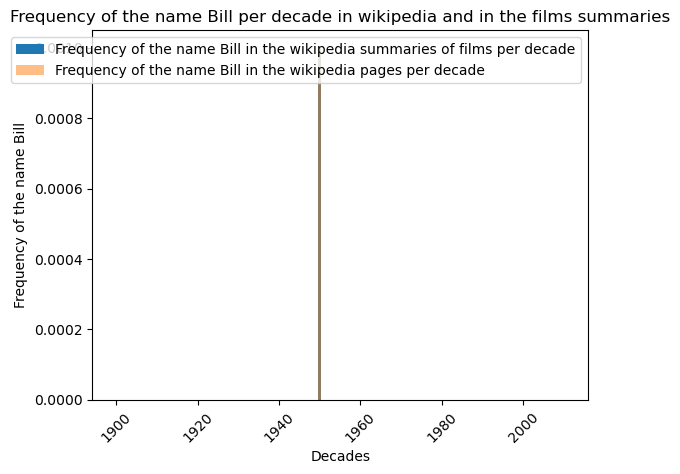

In [28]:
plt.bar(decade_name,wf_wikipedia_summaires_filtered['Bill'], label = 'Frequency of the name Bill in the wikipedia summaries of films per decade')
plt.bar(decade_name,wf_wikipedia_filtered['Bill'], alpha = 0.5 ,label = 'Frequency of the name Bill in the wikipedia pages per decade')
plt.xlabel('Decades')
plt.ylabel('Frequency of the name Bill')
plt.title('Frequency of the name Bill per decade in wikipedia and in the films summaries')
plt.xticks(rotation=45)
plt.legend()
plt.show()

> Obviously the pearson p value is zero. This leads us to think that the name Bill was very popular in the 1950 decade 

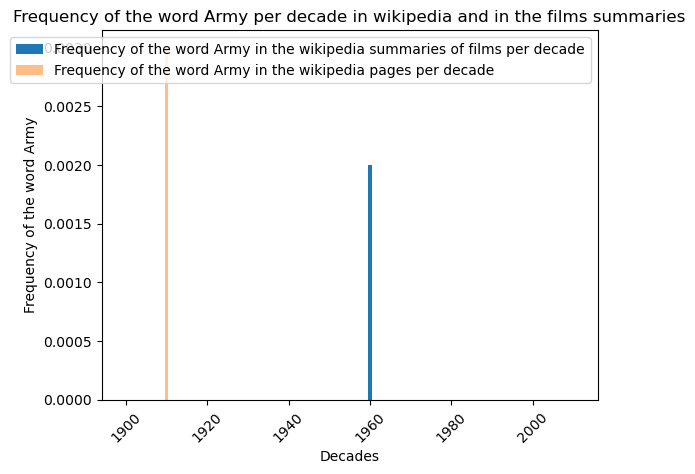

In [29]:
plt.bar(decade_name,wf_wikipedia_summaires_filtered['Army'], label = 'Frequency of the word Army in the wikipedia summaries of films per decade')
plt.bar(decade_name,wf_wikipedia_filtered['Army'], alpha = 0.5 ,label = 'Frequency of the word Army in the wikipedia pages per decade')
plt.xlabel('Decades')
plt.ylabel('Frequency of the word Army')
plt.title('Frequency of the word Army per decade in wikipedia and in the films summaries')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [30]:
#computing the pearson p value 
correlation, p_value = pearsonr(wf_wikipedia_summaires_filtered['Army'], wf_wikipedia_filtered['Army'])
p_value

0.778725396245442

> Like for most of the words in common, again no significant pearson p value was found. 

## *3.4 Conclusion*

> No correlation was found between the most frequent words (except some popular names) of the wikipedia decade pages and of the summaries (either from wikipedia or from plot_summaries).

# 4. Testing methods 

## *4.1 NER with BERT*

> We then use Named Entity Recognition (NER) with the LLM BERT in order to classify the tokenized text into different entities : locations, organizations, persons, and miscellaneous. We apply here this method to the summary of the movie 'The good marriage', adapted to include more adjectives (since the goal is to extract the adjectives from the text.)

> The fist step is to extract all the tokens from the text, each classified as a different entity. They are assigned to an ID, composed of a first letter (B for beginning a new entity, I for inside an entity) and a 3 to 4 letter identifier of the entity (PER for person, LOC for location, ORG for organization, MISC for miscellaneous). Here, we extract the tokens and their IDs.

In [37]:
# test of the ner pipeline on the summary of the movie 'Carbine Williams'
nlp = pipeline("ner", model=model, tokenizer=tokenizer)
test_string='Sabine is a smart student in art history. She is growing tired of the part of the mistress of a painter and family man, Simon. She meets the beautiful, young, rich and free Edmond, and declares that she is going to marry him.'
ner_results = nlp(test_string)
print(ner_results)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'entity': 'B-PER', 'score': 0.99796945, 'index': 1, 'word': 'Sabine', 'start': 0, 'end': 6}, {'entity': 'B-PER', 'score': 0.9979341, 'index': 27, 'word': 'Simon', 'start': 120, 'end': 125}, {'entity': 'B-PER', 'score': 0.99902046, 'index': 39, 'word': 'Edmond', 'start': 173, 'end': 179}]


> Since the tokens do not always represent full words, we need to group them together to form back the words they originated from. To do this, we use the first letter of the identifier to select tokens that are at the start of an entity, and group all the subsequent tokens with them. 

In [38]:
# separating the results into different entities
merged_entities=[]
current_entity = None

for result in ner_results:
    if result['entity'].startswith("B-"):  # meaning the entity is the start of a new group of words
        # Append the current entity if one exists
        if current_entity:
            merged_entities.append(current_entity)
        # Start a new entity from the current one
        current_entity = {
            "entity": result['entity'][2:],  # Strip "B-" or "I-" prefix to get the entity type
            "score": result['score'],
            "word": result['word'].replace("##", ""),  # Remove "##" if it's a subword
            "start": result['start'],
            "end": result['end']
        }
    elif result['entity'].startswith("I-") and current_entity:  # Continuation of the current entity
        # Update the word by adding the next token part (remove "##" if it's a subword)
        current_entity['word'] += result['word'].replace("##", "")
        # Update the end position to the end of this token
        current_entity['end'] = result['end']
        # Optionally update the score to the average of all tokens' scores
        current_entity['score'] = (current_entity['score'] + result['score']) / 2

# Append the final entity after the loop
if current_entity:
    merged_entities.append(current_entity)
print(merged_entities)

[{'entity': 'PER', 'score': 0.99796945, 'word': 'Sabine', 'start': 0, 'end': 6}, {'entity': 'PER', 'score': 0.9979341, 'word': 'Simon', 'start': 120, 'end': 125}, {'entity': 'PER', 'score': 0.99902046, 'word': 'Edmond', 'start': 173, 'end': 179}]


> Since our goal is to study only the characters in the plot summaries, we only extract the entities corresponding to characters (with the identifier 'PER'). Since some of the words can be concatenated by mistake, we separate names of characters containing uppercase letters at another position than the first letter. We also group character names without uppercase at the start with the previous token, since they are generally wrongly split names. 

In [39]:
character_list =[] # create a list of the person type entities among the entities of the decade summaries
for word in merged_entities :
    if(word['entity'])=='PER' : character_list.append(word['word'])
for i in np.arange(len(character_list)-1)+1 :
    name=character_list[i]
    previous_name=character_list[i-1]
    if len(name)<=2:character_list.remove(name) # removing character names shorter than 2 characters
    else :
        if not (name[0].isupper()): # if the first character is not in uppercase, add it to the previous word in the list
            previous_name+=name
            character_list.remove(name)
        else :
            idx_upper=[idx for idx, char in enumerate(name[1:]) if char.isupper()] # indexes of the uppercase letters in the word
            if idx_upper!=[]: 
                idx=idx_upper[0] # only consider the first index (the others are ignored for simplicity, since it is rare to have a word wrongly split in two places simultaneously)
                name_1=name[:idx+1] # separate the word in 2, one part before the uppercase letter, and another starting at the uppercase letter
                name_2=name[idx+1:]
                if (len(name_1)>3): character_list.append(name_1) # check if the newly created words are longer than 2 characters
                if (len(name_2)>3): character_list.append(name_2)
                character_list.remove(name)

character_list=[string for idx,string in enumerate(character_list) if len(string)>2] # removing one last time the words shorter than 2 characters

print(character_list)

['Sabine', 'Simon', 'Edmond']


## *3.3. Testing the "en_core_web_sm' pipeline with Spacy*

> Once we extracted the names of the characters above, we use the en_core_web_sm pipeline for English text processing with spacy to extract the adjectives caracterizing those characters in the text. We finally obtain a list of all the adjectives characterizing the characters in this text.

In [40]:
# testing the llm en_core_web_sm with spacy to extract the adjectives corresponding to the characters
nlp_spacy = spacy.load("en_core_web_sm")

# Creating a list of the adjectives of the characters in the 1940s
adjectives_list=[]

doc = nlp_spacy(test_string)
for token in doc :
    for name in character_list:
        if(token.text==name): # tokens corresponding to character names
            for lefty in token.lefts : # tokens in the dependency tree of the character name
                if(lefty.pos_=='ADJ') : # tokens corresponding to adjectives
                    adjectives_list.append(lefty.text)
print(adjectives_list)

['beautiful', 'young']


> As a conclusion, we can see that not all adjectives were extracted successfully. We are missing 'rich', 'free', and 'smart'. However, when, performed on a large enough dataset, this method is able to extract enough adjectives for a meaningful analysis of the text.

# 4. Sentence Transformer (SBERT) and LLAMA

> In this section, SBERT is used to cluster movie summaries and historical texts from Wikipedia into lexical fields. Then LLAMA is employed to assign meaningful titles to each cluster. These clusters are subsequently correlated to uncover significant relationships between major movie themes and historical events. The results are visualized using heatmaps, bar plots, and bubble plots.

In [ ]:
# Load SBERT model
model = SentenceTransformer('paraphrase-MiniLM-L3-v2')

# Load OllamaLLM model
llm = OllamaLLM(model="llama3.2")

In [ ]:
for decade in tqdm(np.arange(1900, 2010, 10)):
  
  history_sentences = read_and_preprocess(f'src/data/wikipedia_timeline/{decade}s.txt')
  movies_sentences = read_and_preprocess(f'src/data/movies_summaries/summaries_decade_{decade}.txt')

  # Encode sentences into embeddings
  history_embeddings = model.encode(history_sentences, batch_size=32, convert_to_tensor=True)
  movies_embeddings = model.encode(movies_sentences, batch_size=32, convert_to_tensor=True)

  # Compute pairwise similarity matrix
  similarity_matrix = util.pytorch_cos_sim(history_embeddings, movies_embeddings).cpu().numpy()

  # Perform clustering on history dataset
  cluster_model = MiniBatchKMeans(n_clusters=5)
  history_clusters = cluster_model.fit_predict(history_embeddings.cpu().numpy())

  # Cluster sentences from history into semantic fields
  clustered_history_string=''
  clustered_history = {i: [] for i in range(max(history_clusters) + 1)}
  for idx, cluster_id in enumerate(history_clusters):
    clustered_history[cluster_id].append(history_sentences[idx])
    clustered_history_string +=history_sentences[idx]
    clustered_history_string += '\n'
  
  # Save the history clusters in a text file
  with open (f'data/clusters/history/history_clusters_{decade}', "w") as file :
     file.write(clustered_history_string)

  # Perform clustering on movies dataset
  movies_clusters = cluster_model.fit_predict(movies_embeddings.cpu().numpy())

  # Separate movies summaries into clusters
  clustered_movies_string=''
  clustered_movies = {i: [] for i in range(max(movies_clusters) + 1)}
  for idx, cluster_id in enumerate(movies_clusters):
    clustered_movies[cluster_id].append(movies_sentences[idx])
    clustered_movies_string+=movies_sentences[idx]
    clustered_movies_string += '\n'

  # Save the movie clusters in a text file
  with open (f'data/clusters/history/movies_clusters_{decade}', "w") as file :
     file.write(clustered_movies_string)

  # Compute average similarity between clusters from history and movies
  max_similarities = []
  history_cluster_similarities = {i: [] for i in np.arange(len(clustered_history))+1}
  for history_cluster_id, sentences_history in clustered_history.items():
    history_cluster_emb = model.encode(sentences_history, convert_to_tensor=True).mean(dim=0)  # Average embedding for the cluster
    movies_similarities_list=[]
    for movie_cluster_id, sentences_movies in clustered_movies.items():
      movie_cluster_emb = model.encode(sentences_movies, convert_to_tensor=True).mean(dim=0)  # Average embedding 
      similarities = util.pytorch_cos_sim(history_cluster_emb, movie_cluster_emb).cpu().numpy()
      similarity = similarities[0][0]
      movies_similarities_list.append(similarity)
    print(movies_similarities_list)
    history_cluster_similarities[history_cluster_id+1]=movies_similarities_list  # Store similarities
    max_similarities.append(max(movies_similarities_list))  # Store max similarity for the bar plot


  # Initialize memory to keep the conversation context
  memory = ConversationBufferMemory()
  memory.clear()

  # Create a conversational chain with the model and memory
  conversation = ConversationChain(llm=llm, memory=memory)


  # Generate titles for history clusters
  history_cluster_names_string=''
  history_cluster_names=[]
  for i in tqdm(range(5)):
      # clear memory
      memory = ConversationBufferMemory()
      memory.clear()

      text=clustered_history[i]

      response1 = conversation.run(text)

      if(i!=0) : other_names= ''
      else : other_names=history_cluster_names_string

      # Generate a unique, descriptive one-word topic name for the cluster
      response3=conversation.run(f"From the most important key point of the previous text, give me an easily understandable one word topic, differerent from the topics : {other_names} and from the topic 'decade'. Give only 1 word, no addititonal text.")

      name=response3.replace('*','')
      name=response3.replace('.','')
      history_cluster_names.append(name)
      if i!=5 : name+=','
      history_cluster_names_string+=name

  # Generate titles for movie clusters
  movies_cluster_names_string=''
  movies_cluster_names=[]
  for i in tqdm(range(5)):
      # clear memory
      memory = ConversationBufferMemory()
      memory.clear()

      text=clustered_movies[i]

      response1 = conversation.run(text)

      if(i!=0) : other_names= ''
      else : other_names=movies_cluster_names_string

      # Generate a unique, descriptive one-word topic name for the cluster
      response3=conversation.run(f"From the most important key point of the previous text, give me an easily understandable one word topic, differerent from the topics : {other_names} and from the topic 'decade' and from the topic 'movie'. Give only 1 word, no addititonal text.")

      name=response3.replace('*','')
      name=response3.replace('.','')
      movies_cluster_names.append(name)
      if i!=5 : name+=','
      movies_cluster_names_string+=name

  # Save bar plot data (Maximum similarity per cluster)
  bar_plot_data = pd.DataFrame({
      'Cluster ID': history_cluster_names,
      'Max Similarity': max_similarities
  })
  bar_plot_data.to_csv(f'data/max_similarity_plots_data/bar_plot_data_{decade}.csv', index=False)

  # Save heatmap data (similarity matrix)
  heatmap_data = pd.DataFrame(history_cluster_similarities)
  heatmap_data
  heatmap_data.index=movies_cluster_names
  heatmap_data.columns=history_cluster_names
  heatmap_data.to_csv(f'data/heatmap_plots_similarity_data/heatmap_data_{decade}.csv')

In [5]:
# Generate heatmaps of clusters correlations for each decade
for decade in np.arange(1900, 2010, 10):
    
    df = pd.read_csv(f'src/data/heatmaps_data/heatmap_data_{decade}.csv', index_col=0)

    # Extract x-axis and y-axis labels
    x_labels = df.columns.tolist()
    y_labels = df.index.tolist()

    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
        z=df.values,  
        x=x_labels,   
        y=y_labels,   
        colorscale='YlOrRd', 
    ))

    # Add title and labels
    fig.update_layout(
    title= f'Correlation between history and movies summaries clusters for {decade}s',
    title_x=0.5,  
    title_font=dict(size=18),  
    xaxis_title="History",  
    yaxis_title="Movies" 
    )

    fig.show()

    # Save the heatmap in html format
    fig.write_html(f'html/heatmaps/heatmap_{decade}.html')

In [6]:
# Timeline of max similarities

df = pd.read_csv('src/data/max_similarities_data.csv')

df['Cluster'] = df['History cluster'].astype(str)  

# Create the bar plot
fig = px.bar(df, x='Decade', y='Similarity',
             labels={'Similarity': 'Max Corr in Movies Summaries'}, height=400)

# Add cluster names on top of each bar
fig.update_traces(text=df['Cluster'], textposition='outside', texttemplate='%{text}', textfont_size=10, textfont_weight='bold')

colors = ['#ba3c3c', '#dc6c3a']  
fig.update_traces(marker_color=[colors[i % len(colors)] for i in range(len(df))])

# Hide the legend
fig.update_layout(showlegend=False)

fig.show()

# Save the plot in html format
fig.write_html('html/max_similarities_plot.html')

In [7]:
# Create a bubble chart of higher correlations

df = pd.read_csv('src/data/higher_correlations_data.csv')

# Ensure 'Decade' is treated as a categorical variable by converting it to string
df['Decade'] = df['Decade'].astype(str)

# Normalize the Correlation column to a range between 0 and 1 to see the differences better
df['Normalized Correlation'] = (df['Correlation'] - df['Correlation'].min()) / (df['Correlation'].max() - df['Correlation'].min())

# Create the bubble chart
fig = px.scatter(
    df,
    x='Movies cluster',
    y='History cluster',
    size='Normalized Correlation',   
    size_max=40,                     
    color='Decade',                  
    color_discrete_sequence=px.colors.sequential.Turbo_r,  
    height=400,
    labels={
        "Movies cluster": "Movies Clusters",
        "History cluster": "History Clusters",
        "Correlation": "Correlation Coefficient",
        "Decade": "Decade"
    }
)

# Update layout to add a title and set the legend properties
fig.update_layout(
    legend_title_text='Decade',  # Set the title of the legend
    legend=dict(
        title_font=dict(size=14, color="black"),
        font=dict(size=12),
        bgcolor="rgba(255, 255, 255, 0.7)",  # Semi-transparent background
        bordercolor="black",
        borderwidth=1,
    ),
    title={
        'text': 'Higher Correlations between History and Movies Summaries Clusters',
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='Movies Clusters',
    yaxis_title='History Clusters',

)

fig.update_layout(height=500, width=800)

fig.show()

# Save the plot in html format
fig.write_html('html/higher_correlations_plot.html')

# 4. Feasibility with two examples

> The goal of this part is to evaluate the feasability of the pipeline on a subset of the data. We chose to analyze the decades 1940 and 1980, since they are far apart enough to show significant differences in data analysis. Moreover, they contain enough movies for a relevant analysis. 

## *4.1 Study of the 1940 decade*

### *4.1.1 Study of the 1940 decade with the LDA Model*

> To start the study of this decade with LDA Model, we are first going to transfer the data of the dictionnary summaries_per_decade into a dataframe and concatenate all the summaries into one cell.

In [19]:
summaries_40s = summaries_per_decade[1940]
summaries_40s_df = pd.DataFrame(summaries_40s, columns=["plot_summary"])

all_summaries_40s = summaries_40s_df['plot_summary'].str.cat(sep=' ')
all_summaries_40s = pd.DataFrame({'all_summaries': [all_summaries_40s]})
print("concatenated version:", all_summaries_40s)

concatenated version:                                        all_summaries
0  Hayworth stars as the Muse Terpsichore who is ...


> We can then apply the method tested in the part 3.1 to the dataframe to extract the most frequent words and their frequencies. We get in return a list of the frequencies and the words, that we stock into a new dataframe

In [22]:
print(all_summaries_40s.shape)

#Use the created functions to get the most frequents words and their frequencies

all_summaries_40s['split'] = all_summaries_40s['all_summaries'].apply(text_split)
all_summaries_40s['corpus'] = all_summaries_40s['split'].apply(bag_of_words)
all_summaries_40s['lda'] = all_summaries_40s.apply(lda, axis=1)

#Print the resulting serie
pprint(all_summaries_40s['lda'].apply(get_topics).tolist())

#Collect the serie in a variable
word_freq_40s = all_summaries_40s['lda'].apply(get_topics)

(1, 4)
[[(0,
   '0.004*"tells" + 0.003*"man" + 0.003*"love" + 0.003*"Bugs" + 0.003*"finds" '
   '+ 0.003*"tries" + 0.003*"home" + 0.003*"time" + 0.002*"police" + '
   '0.002*"wife" + 0.002*"night" + 0.002*"Jerry" + 0.002*"house" + '
   '0.002*"film" + 0.002*"life" + 0.002*"money" + 0.002*"way" + 0.002*"father" '
   '+ 0.002*"becomes" + 0.002*"leaves" + 0.002*"turns" + 0.002*"woman" + '
   '0.002*"returns" + 0.002*"friend" + 0.002*"help" + 0.002*"Dr" + 0.002*"men" '
   '+ 0.002*"death" + 0.002*"family" + 0.002*"decides" + 0.002*"story" + '
   '0.002*"town" + 0.002*"mother" + 0.002*"room" + 0.002*"day" + '
   '0.002*"begins" + 0.002*"work" + 0.001*"husband" + 0.001*"Daffy" + '
   '0.001*"falls" + 0.001*"head" + 0.001*"asks" + 0.001*"escape" + '
   '0.001*"sees" + 0.001*"son" + 0.001*"end" + 0.001*"job" + 0.001*"train" + '
   '0.001*"arrives" + 0.001*"runs"')]]


> We use the function extract to stock the data in a form easier to plot. We set the word as the index of the dataframe.

In [23]:
topics_40s = extract(word_freq_40s)
topics_40s.set_index('word', inplace = True)

> We can now plot the frequencies of the words in a bar plot.

<Figure size 1000x600 with 0 Axes>

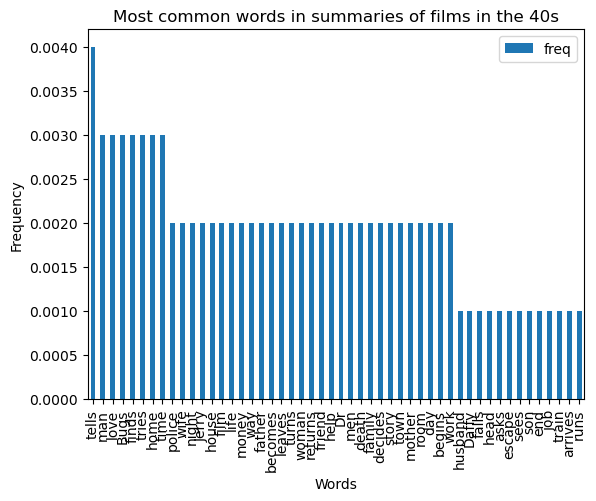

In [24]:
#Plot the freqencies of the words
plt.figure(figsize=(10, 6))
topics_40s.plot(kind='bar')

plt.title('Most common words in summaries of films in the 40s')
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.show()

> We can see that the bar a distributed like stairs. This is a limitation of the LDA Model of Gensim that returns frequencies with only a limited number of decimals. 

## *4.2 Study of the 1980 decade*

### *4.2.1 Study of the 1980 decade with the LDA Model*

> With this new decade, we apply the same method as before.First we transfer the data of the dictionnary summaries_per_decade into a dataframe and concatenate all the summaries into one cell.

In [26]:
summaries_80s = summaries_per_decade[1980]
summaries_80s_df = pd.DataFrame(summaries_80s, columns=["plot_summary"])

all_summaries_80s = summaries_80s_df['plot_summary'].str.cat(sep=' ')
all_summaries_80s = pd.DataFrame({'all_summaries': [all_summaries_80s]})
print("concatenated version:", all_summaries_80s)

concatenated version:                                        all_summaries
0  Eva, an upper class housewife, becomes frustra...


> We extract the most frequent words and their frequencies using text_split. We get in return a list of the frequencies and the words, that we stock into a new dataframe.

In [27]:
print(all_summaries_80s.shape)

#Use the created functions to get the most frequents words and their frequencies

all_summaries_80s['split'] = all_summaries_80s['all_summaries'].apply(text_split)
all_summaries_80s['corpus'] = all_summaries_80s['split'].apply(bag_of_words)
all_summaries_80s['lda'] = all_summaries_80s.apply(lda, axis=1)

#Print the resulting serie
pprint(all_summaries_80s['lda'].apply(get_topics).tolist())

#Collect the serie in a variable
word_freq_80s = all_summaries_80s['lda'].apply(get_topics)

(1, 1)
[[(0,
   '0.004*"film" + 0.004*"love" + 0.004*"father" + 0.004*"life" + 0.003*"man" '
   '+ 0.003*"time" + 0.003*"home" + 0.003*"tells" + 0.003*"family" + '
   '0.003*"house" + 0.003*"finds" + 0.003*"mother" + 0.003*"wife" + '
   '0.002*"day" + 0.002*"son" + 0.002*"police" + 0.002*"help" + 0.002*"tries" '
   '+ 0.002*"money" + 0.002*"night" + 0.002*"story" + 0.002*"friend" + '
   '0.002*"becomes" + 0.002*"friends" + 0.002*"daughter" + 0.002*"men" + '
   '0.002*"car" + 0.002*"decides" + 0.002*"woman" + 0.002*"way" + '
   '0.002*"death" + 0.002*"begins" + 0.002*"years" + 0.002*"girl" + '
   '0.002*"leaves" + 0.002*"meets" + 0.002*"town" + 0.002*"school" + '
   '0.002*"returns" + 0.002*"asks" + 0.002*"end" + 0.001*"falls" + '
   '0.001*"group" + 0.001*"work" + 0.001*"kill" + 0.001*"return" + '
   '0.001*"become" + 0.001*"ends" + 0.001*"people" + 0.001*"village"')]]


> We use the function extract to stock the data in a form easier to plot. We set the word as the index of the dataframe.

In [28]:
topics_80s = extract(word_freq_80s)
topics_80s.set_index('word', inplace = True)

> We can now plot the frequencies of the words in a bar plot.

<Figure size 1000x600 with 0 Axes>

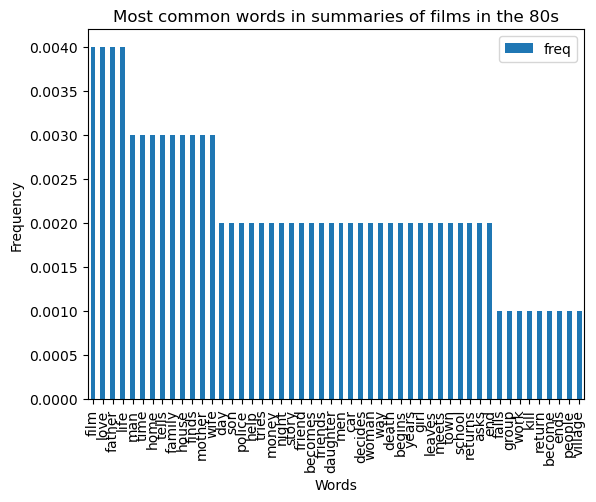

In [29]:
#Plot the freqencies of the words
plt.figure(figsize=(10, 6))
topics_80s.plot(kind='bar')

plt.title('Most common words in summaries of films in the 80s')
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.show()

> We obtain a bar plot with different frequencies of the most common words. We can see that the four more common words in the summaries of films released in the 80s are 'film', 'love', 'father' and 'life'.

>In conclusion, looking back at the plot of the most common words in the 40s, we can see that we have many words in common, like 'love', 'man' or 'home'. We see that we also get many verbs, that we are not suppose to have, this also shows a limitation, this time of NLTK. With some more tests, not shown in this part, we can see that NLTK's `pos_tag` function, used by the `text_split` function, which is supposed to tag words with their grammatical class, struggles to differentiate nouns from verbs.

>For the P3, we could push the analysis a little further by sorting the most frequent words so as to keep only those that are unique to the decade. This could yield information more specific to the decade under study. We could also extend our study to adjectives, in order to compare the outputs of the LDA to the outputs of the other methods.

# 5. Conclusion 